In [38]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import random
import csv
from datetime import datetime
import time

from langchain.schema.runnable import RunnableSequence

In [2]:
# Do imports for squad_scoring and prompts
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))

utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))

utils_folder = Path(".")
sys.path.append(str(utils_folder))

import squad_scoring
import deh_prompts
import deh_vector_store
import deh_squad_data
import deh_hyde
from deh_llm import get_llm

##### Set Global variables

In [ ]:
# # Folders for storing data and the results
DATA_ROOT = "../../../deh_data_results/data"         # Set to your own data folder
RESULTS_ROOT = "../../../deh_data_results/results"   # Set to your own results folder
HYDE_BASED_CONTEXTS_ROOT = F"{DATA_ROOT}/hyde_based_contexts"   # Set to your own results folder

# SQuAD dataset
data_file = f"{DATA_ROOT}/dev-v2.0.json"
dataset = squad_scoring.load_dataset(data_file)

# # Vector Store Parameters
VECTOR_STORE_TOP_K = 5
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 100
DEFAULT_CHROMA_PREFIX = "deh_rag"
#DEFAULT_CHROMA_COLLECTION = "per_article"
DEFAULT_CHROMA_COLLECTION = "per_article"
CHUNK_SQUAD_DATASET = False        # Set to True to vectorize the squad dataset. If False, 
                                   # then the documents and their embeddings should already
                                   # exist in the vector store.

# # CONTEXT Creation Parameters
REFRESH_QUESTION_CONTEXTS = False   # Set to True to create question contexts from the vector store; 
                                    # if False, the question contexts are loaded from a csv file.
REFRESH_HYDE_CONTEXTS = False       # Set to True to create hyde contexts; if False,
#                                   # the hyde contexts are loaded from a csv file.                                    

READ_QAS_FROM_FILE = False

# # Bootstrap Parameters
SAMPLE_SIZE = 150
BOOTSTRAPS_N = 10000

# Timing
execution_times = {}

# #TODO check if setting the seed makes sense
# # SEED = 42
# # set_seed = random.seed(SEED)

# PERSIST_ANSWER_SAMPLES = False   # Set to True to persist the llm answers for each sample, for each experiment


##### Loading SQuAD data

In [4]:
csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

print(f"Loading squad data...")

column_names = ["title", "squad_context", "qid", "question", "is_impossible", "answer"]
squad_raw = pd.read_csv(f"{DATA_ROOT}/squad_raw.csv", names=column_names, skiprows=1)
df_squad_raw = pd.DataFrame(squad_raw)
df_squad_raw.head(5)

df_titles = pd.DataFrame(df_squad_raw['title'].unique(), columns=["title"])
df_contexts = pd.DataFrame(df_squad_raw['squad_context'].unique(), columns=["squad_context"])
print(f"Number of unique contexts: {len(df_contexts)}")

df_qas = df_squad_raw[['qid', 'question', 'squad_context']].drop_duplicates()
df_qas.head(5)
print(f"Number of unique questions: {len(df_qas)}")
           
            

Loading squad data...
Number of unique contexts: 1204
Number of unique questions: 11858


In [5]:
squad_raw.head()

,title,squad_context,qid,question,is_impossible,answer
0,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
1,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
2,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
3,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
4,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,False,10th and 11th centuries


##### Loading qas with contexts data

In [6]:
# Loading the question contexts from the CSV file
qas_with_contexts_csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

df_qas_with_contexts = pd.read_csv(qas_with_contexts_csv_file_path) #, names=column_names)

# drop the answer column if it exists, since it leads
# to duplicates
if 'answer' in df_qas_with_contexts.columns:
    df_qas_with_contexts = df_qas_with_contexts.drop(columns=['answer'])

df_qas_with_contexts = df_qas_with_contexts.drop_duplicates()
print(f"Rows in dataframe df_qas_with_contexts: {len(df_qas_with_contexts)}")
hyde_articles_cnt = df_qas_with_contexts['hyde_article'].notna().sum()
hyde_based_contexts_cnt = df_qas_with_contexts['hyde_based_context'].notna().sum()
print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

# Rewrite the file, since answer column was removed
df_qas_with_contexts.to_csv(qas_with_contexts_csv_file_path, index=False)


Rows in dataframe df_qas_with_contexts: 1522
Number of questions with Hyde articles: 526
Number of questions with Hyde based contexts: 526


##### Get Hyde data (articles and Hyde-based contetxts)

In [7]:
hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
df_hyde_based_contexts = pd.read_csv(hyde_based_context_path)

print(f"Rows in dataframe df_hyde_based_contexts: {len(df_hyde_based_contexts)}")
hyde_articles_cnt = df_hyde_based_contexts['hyde_article'].notna().sum()
hyde_based_contexts_cnt = df_hyde_based_contexts['hyde_based_context'].notna().sum()
print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

Rows in dataframe df_hyde_based_contexts: 3924
Number of questions with Hyde articles: 3924
Number of questions with Hyde based contexts: 0


##### Show names of all dataframes

In [8]:
import copy 

print("Names of Dataframes and their lenghts:\n")
global_keys_copy = copy.deepcopy(list(globals().keys()))

my_l = [{n: len(globals()[n])} for n in global_keys_copy if n.startswith("df_")]
df_dfs = pd.DataFrame([(k, v) for d in my_l for k, v in d.items()], columns=['df name', 'rows'])
df_dfs


Names of Dataframes and their lenghts:



,df name,rows
0,df_squad_raw,26232
1,df_titles,35
2,df_contexts,1204
3,df_qas,11858
4,df_qas_with_contexts,1522
5,df_hyde_based_contexts,3924


##### Intialize the Vector Store (Chroma; Milvus not yet included)

In [9]:
contexts = list(df_contexts["squad_context"].values)
if CHUNK_SQUAD_DATASET:    
    deh_vector_store.chunk_squad_dataset(contexts, dataset, CHUNK_SIZE, CHUNK_OVERLAP)
else:
    print("Chunking not foreseen. Skipping chunking.")

Chunking not foreseen. Skipping chunking.


In [10]:
# Intiialize the Chroma vector store
vector_store = deh_vector_store.get_vector_store(DEFAULT_CHROMA_PREFIX, DEFAULT_CHROMA_COLLECTION)

##### Get hyde-based contexts

Always get hyde-based contexts that already exist and these to the qas dataset

In [11]:
# if not READ_QAS_FROM_FILE:
#     hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
#     hyde_based_contexts, questions_already_processed = deh_hyde.get_hyde_based_contexts(hyde_based_context_path)
#     print(f"Number of questions with hyde-based context: {len(questions_already_processed)}")

In [12]:
# if not READ_QAS_FROM_FILE:
#     # Now add the hyde-based contexts to the qas dataset
#     def get_hyde_based_info_from_qid(qid):
#         for hbc in hyde_based_contexts:
#             if hbc["qid"] == qid:
#                 return (hbc["hyde_article"], hbc["hyde_based_context"])
#         return ("", "")

#     for qa in qas:
#         qid = qa["qid"]
#         hyde_article, hyde_based_context = get_hyde_based_info_from_qid(qid)
#         qa["hyde_article"] = hyde_article
#         qa["hyde_based_context"] = hyde_based_context


##### Normal (i.e. not hyde-based) Question Contexts

Questions:

- if configured, either: generate normal question contexts and then persist
- or: read the question contexts from a .csv file


In [13]:
def persist_question_contexts(qas, csv_file_path):

    # Write the the qas dataset including the question contexts to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        fieldnames = ["title", "context", "qid", "question", "is_impossible",
                      "answer", "hyde_article", "hyde_based_context", "question_context"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()   # Write the header row
        writer.writerows(qas)  # Write the data rows

    print(f"Data successfully written to {csv_file_path}")


In [14]:
# Refresh question contexts (normal contexts and hyde-based contexts)
if REFRESH_QUESTION_CONTEXTS or REFRESH_HYDE_CONTEXTS:
    print(f"Generating question contexts for the dataset and persisting these in a csv file...")

    for i, qa in enumerate(qas):
        if i %100 == 0:
            print(f"Processing question {i}...")

        if REFRESH_QUESTION_CONTEXTS:
            question = qa["question"]
            
            top_docs = vector_store.similarity_search(
                query = question,
                k = VECTOR_STORE_TOP_K,
            )
            qa["question_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

        if REFRESH_HYDE_CONTEXTS:
            hyde_article = qa["hyde_article"]
            if len(hyde_article) > 0:
                #print(f"hyde_article: {hyde_article}")
                top_docs = vector_store.similarity_search(
                    query = hyde_article,
                    k = VECTOR_STORE_TOP_K,
                )

                qa["hyde_based_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

    persist_question_contexts(qas, csv_file_path)



##### Define functions that are needed for experiments

In [15]:
# Create the runnable chain
def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [16]:
# Get the Hyde context for a question
def get_hyde_based_context(question):
    hyde_based_context = df_qas_with_contexts[df_qas_with_contexts["question"] == question]
    if hyde_based_context.empty:
        return None
    else:
        return hyde_based_context["hyde_based_context"].values[0]
    

In [17]:
# generate the LLM answers, using a runnable chain and the sample of questions provided
def generate_llm_answers(runnable_chain, qas_sample, hyde=False):
    
    preds = {}

    sample_size = len(qas_sample)
    print(f"sample_size: {sample_size}")

    for i, qa in enumerate(qas_sample):

        question = qa["question"]
        if hyde:
            #context = qa["hyde_context"]
            context = get_hyde_based_context(question)
        else:
            context = qa["vector_store_context"]
            
        # print(f"question --> {question}")
        # print(context)
        response = runnable_chain.invoke({"context": context, "question": question})
                
        qid = squad_scoring.get_qid_from_question(question, dataset)
        
        if response.content.upper() == "DONT KNOW":
            llm_answer = ""
        else:
            llm_answer = response.content

        preds[qid] = llm_answer
        qas_sample[i]["llm_answer"] = llm_answer

    return preds


In [18]:
#%%capture

# Get the metrics for a set of predictions (preds) that have been generated in a run
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]


In [19]:
# Calculate the mean and confidence interval for a list of scores
# TODO: Check if this is calculation is correct !!
def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    sample_std_dev = np.std(scores_l, ddof=1)
    margin_of_error = 1.96 * sample_std_dev
    ci = (max(mean - margin_of_error, 0), min(mean + margin_of_error, 100))
    # if ci[0] < 0:
    #     ci = (0, ci[1])
    # if ci[1] > 100:
    #     ci = (ci[0], 100)

    return mean, ci

In [ ]:


# Generate a histogram for a list of scores and persist it
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)
    # # Configure major and minor ticks
    # major_tick_locator = MultipleLocator(10)  # Major ticks every 10
    # minor_tick_locator = MultipleLocator(5)   # Minor ticks every 5
    # ax = plt.gca()  # Get the current axis
    # ax.xaxis.set_major_locator(major_tick_locator)
    # ax.xaxis.set_minor_locator(minor_tick_locator)

    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N} - Sample Size: {SAMPLE_SIZE})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    max_len = 6
    mean_label = f"{mean: .2f}".rjust(max_len)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1:          {mean_label}')

    # Add vertical lines for the 95% confidence interval
    #lower = f"{str(round(ci[0], 2))}"    .rjust(5)
    lower = f"{ci[0]: .2f}".rjust(max_len)
    upper = f"{ci[1]: .2f}".rjust(max_len)
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Lower:  {lower}")
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Upper:  {upper}")

    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MultipleLocator(10))  # Major ticks every 10 units
    ax.xaxis.set_minor_locator(MultipleLocator(5))   # Minor ticks every 5 units
    ax.yaxis.set_major_locator(MultipleLocator(10))   # Example: Major ticks every 5 units on the y-axis
    #ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(data)))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # Customize grid for major and minor ticks
    ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5)

    # # Configure major ticks
    # ax = plt.gca()  # Get current axis
    # ax.xaxis.set_major_locator(MultipleLocator(10))  # Major ticks every 10 units
    # #ax.yaxis.set_major_locator(MultipleLocator(5))   # Major ticks every 5 units (example)
    # ax.xaxis.set_minor_locator(MultipleLocator(5))  # Major ticks every 10 units

    # # Optionally customize the grid (if you want grid lines on major ticks)
    # ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)

    plt.legend(prop={'family': 'monospace', 'size': 10})
    plt.legend(loc='upper right', fontsize=10)

    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))
    return plt

##### Define functions for Bootstrapping

In [21]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [22]:
def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    # add each answer to the all_preds
    preds = {}
    all_preds= {}
    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed:
            if experiment_name == "BASIC_RAG_HYDE":
                context = qa["hyde_based_context"]
            elif experiment_name == "FULL_RAG":
                context = qa["question_context"] + "\n\n" + qa["hyde_based_context"]
            else:
                context = qa["question_context"]
            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        llm_answer = response.content

        if llm_answer.upper() == "DONT KNOW":
            if suppress_answers:
                continue
            else:
                llm_answer = ""

        preds[qid] = llm_answer
        all_preds[qid] = llm_answer

        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        preds = {}
        qa[f"{experiment_name.lower()}_llm_answer"] = llm_answer
        qa[f"{experiment_name.lower()}_f1"] = f1
        qa[f"{experiment_name.lower()}_precision"] = precision
        qa[f"{experiment_name.lower()}_recall"] = recall

    return all_preds
        

In [23]:
def persist_results(results_folder_name, experiment_name, df):

    # if not os.path.exists(results_folder_name):
    #     os.makedirs(results_folder_name)
    # print(f"results_folder_name: {results_folder_name}")
    # df = pd.DataFrame(qas)
    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)

In [24]:
def clip_scores(scores_l, clip_perc):
    scores_sorted_l = sorted(scores_l)

    clip_cnt = int(len(scores_sorted_l) * clip_perc / 100)
    print(f"clip_cnt: {clip_cnt}")

    # Now clip both ends by clip_perc percent
    clipped_scores_l = scores_sorted_l[clip_cnt:-clip_cnt] if clip_cnt > 0 else scores_sorted_l
    return clipped_scores_l


In [25]:
def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):

    mu_hats = []
    n = len(scores_l)
    scores_l = clip_scores(scores_l, 2.5)
    #print(f"scores_l: {scores_l}")
    for i in range(bootstraps_n):
        if i % 100 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    #print(f"mu_hats: {mu_hats}")
    plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)
    plt.show();
    #plt.clf();

In [26]:
# def do_bootstrapping_all_preds(all_preds, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):

#     mu_hats = []
#     n = len(all_preds)
#     all_preds_list = [{k: v} for k, v in all_preds.items()]

#     for i in range(bootstraps_n):
#         if i % 100 == 0:
#             print(f"Processing sample {i}...")

#         # TODO: There is likely a much more efficient way to implement this
#         sample_idxs = random.choices(range(n), k=n)
#         bootstrap_sample_preds = {}
#         for i in sample_idxs:
#             pred = all_preds_list[i]
#             bootstrap_sample_preds.update(pred)
#             #print(f"pred: {pred}")
#             #my_sample_preds[] = pred

#         #bootstrap_sample_preds = random.choices(all_preds, k=n) # sample with replacement

#         scores = squad_scoring.calc_squad_metrics(dataset, bootstrap_sample_preds)
#         #mu_hat = np.mean(bootstrap_sample)
#         mu_hats.append(scores["f1"])

#     bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
#     #print(f"mu_hats: {mu_hats}")
#     plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name + "_all_preds")
#     plt.show()
#     plt.clf()

In [27]:
# my_preds=  {'5726a7ecf1498d1400e8e657': 'The Treaty of Rome, Article 81.', '5ad26a5fd7d075001a429318': 'Work or sliding motion, depending on force applied.', '5ad3bb12604f3c001a3feeba': 'Unified command structure to focus Prussian war effort.', '56de49a8cffd8e1900b4b7a9': 'The company sold its rights to a new owner.', '5ad565575b96ef001a10adb3': 'A solution that combines both problems.', '573312fcd058e614000b56e6': "Monocle's Quality of Life Survey, 2021.", '5729f2646aef051400155132': 'Approximately 200,000 metric tons of live plants.', '5a38d93da4b263001a8c195b': '1940, marking a significant shift in global oil dominance.', '5726701add62a815002e84c9': 'At the base of a mountain or fault block.', '5729fd111d046914007796a9': 'RNA interference (RNAi) technology.', '57287ccb2ca10214002da3da': 'The Mongol Empire, under Kublai Khan.', '5ad502385b96ef001a10a958': 'The history of the Polish Winged Hussars.', '5ad04de377cf76001a686fa6': 'The state of California, USA.', '57300888b2c2fd1400568778': 'Colonia Nova Roma.', '5727e6cbff5b5019007d97f2': 'They dispute criticism, citing methodology and data reliability concerns.', '572ff56304bcaa1900d76f2e': 'The water flows into the Oude Rijn river.', '572fb059947a6a140053cb84': 'The Painted Hall in Westminster Palace.', '5728fc2eaf94a219006a9ecb': 'Intercourse with semen.', '570611c475f01819005e793d': 'Port of New York/New Jersey.', '5ad0278077cf76001a686be6': 'The boat skylights are located in the Grand Lobby.', '5ad5316b5b96ef001a10ab74': 'Tasks requiring human intuition, creativity, or moral judgment.', '5ad40419604f3c001a3ffdb8': 'The Philippines, Indonesia, Malaysia, and Japan are examples.', '5a25e4a2ef59cd001a623d0b': 'The time element in construction is called "time bar".', '5a25d529ef59cd001a623cf0': 'When a builder takes on excessive risk themselves.', '5727e8424b864d1900163fc0': 'About 160 million, or roughly half the population.', '5a638bf768151a001a922365': 'Around 25% globally, according to recent data.', '5a3e44ea378766001a002534': 'Famous historical figures, such as Galileo and Copernicus.', '57302bd0b2c2fd14005689dd': 'The Islamic State proclaimed itself as a caliphate.', '571a53d410f8ca1400304fe5': 'Crust, composed of minerals like olivine and pyroxene.', '5acfe89777cf76001a686411': 'Egyptian secular democracies, such as Tunisia.'}
# my_list = [{k: v} for k, v in my_preds.items()]
# my_n = len(my_list)
# print(f"my_n: {my_n}")

# my_sample = random.choices(range(my_n), k=my_n)
# print(f"my_sample: {my_sample}")
# print(f"my_list: {my_list}")
# my_sample_preds = {}
# for i in my_sample:
#     pred = my_list[i]
#     my_sample_preds.update(pred)
#     #print(f"pred: {pred}")
#     #my_sample_preds[]
# print(f"my_sample_preds: {my_sample_preds}")
# print(f"len(my_sample_preds): {len(my_sample_preds)}")

In [28]:
def create_results_folder(experiment_name):
    start_timestamp_str = get_timestamp_as_string()
    results_folder_name = f"{RESULTS_ROOT}/{experiment_name}/results_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [51]:
def conduct_experiment(qas, experiment_name, query_prompt_idx, context_needed=False, suppress_answers=False):

    start_time = time.perf_counter()

    print(f"============= Creating results folder for {experiment_name} =============")
    results_folder_name = create_results_folder(experiment_name)
    
    print(f"============= Calculating scores for {experiment_name} =============")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}")
    all_preds = calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, suppress_answers)
    print(f"all_preds: {all_preds}")

    print(f"============= Persisting results for {experiment_name} =============")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df)

    print(f"\n============= Bootstrapping for {experiment_name} =============")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")
    do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)
    # print(f"\nBOOTSTRAPS_N for all_preds: {BOOTSTRAPS_N}")
    # do_bootstrapping_all_preds(all_preds, results_folder_name, experiment_name, BOOTSTRAPS_N)

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times[experiment_name] = execution_time
    return execution_time

##### Creating a sample from qas for bootstrapping and bootstrapping with Hyde (will be used for all experiments)

In [42]:
df_qas_for_bootstrapping = df_qas_with_contexts[['qid', 'question', 'question_context', 'hyde_based_context']]
df_qas_for_bootstrapping_sample = df_qas_for_bootstrapping.sample(n=SAMPLE_SIZE, replace=True)
ldict_qas_for_boostrapping_sample = df_qas_for_bootstrapping_sample.to_dict(orient='records')
#ldict_qas_for_boostrapping

df_qas_for_hyde_bootstrapping = df_qas_for_bootstrapping[df_qas_for_bootstrapping['hyde_based_context'].notna()]
df_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping.sample(n=SAMPLE_SIZE, replace=True)
ldict_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping_sample.to_dict(orient='records')


In [31]:
# # Getting qid, question, question_context
# qas_for_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "question_context": qa["question_context"]} for qa in qas]
# # Removing duplicates
# qas_for_bootstrapping = list({frozenset(item.items()): item for item in qas_for_bootstrapping}.values())
# # Taking a sample of size SAMPLE_SIZE
# qas_for_bootstrapping = random.sample(qas_for_bootstrapping, SAMPLE_SIZE)
# len(qas_for_bootstrapping)

# qas_for_hyde_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "hyde_based_context": qa["hyde_based_context"], "question_context": qa["question_context"]} for qa in qas if len(qa["hyde_based_context"]) > 0]
# # Removing duplicates
# qas_for_hyde_bootstrapping = list({frozenset(item.items()): item for item in qas_for_hyde_bootstrapping}.values())
# # Taking a sample of size SAMPLE_SIZE for hyde experiment
# qas_for_hyde_bootstrapping = random.sample(qas_for_hyde_bootstrapping, SAMPLE_SIZE)


##### Calculate Resulst for NO_RAG

============= Creating results folder for NO_RAG =============
============= Calculating scores for NO_RAG =============
SAMPLE_SIZE: 500
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Use ten words maximum and keep the answer concise.

    Question: {question}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing question 130...
Processing question 140...
Processing question 150...
Processing question 160...
Processing question 170...
Processing question 180...
Processing question 190...
Processing question 200...
Processing question 210...
Processing question 220...
Processing question 230...
Processing question 240...
Processing question

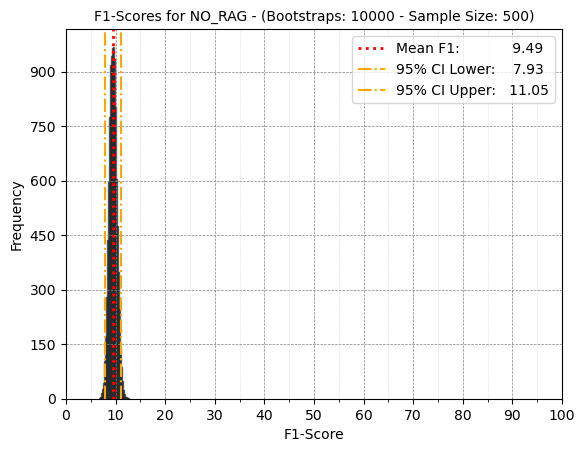

In [32]:
conduct_experiment(ldict_qas_for_boostrapping_sample, "NO_RAG", 0, context_needed=False)

In [33]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator

# # Sample data
# x = range(0, 101)
# y = [value**0.5 for value in x]

# # Create the plot
# plt.plot(x, y)

# # Set the range for the x-axis
# plt.xlim(0, 100)

# # Configure major and minor ticks
# major_tick_locator = MultipleLocator(10)  # Major ticks every 10
# minor_tick_locator = MultipleLocator(5)   # Minor ticks every 5

# # Apply tick locators to the x-axis
# ax = plt.gca()  # Get the current axis
# ax.xaxis.set_major_locator(major_tick_locator)
# ax.xaxis.set_minor_locator(minor_tick_locator)

# # Optionally, customize the grid
# ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
# ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# # Add labels and title
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.title("Plot with Major and Minor Ticks")

# # Show the plot
# plt.show()

##### Calculating scores for BASIC_RAG

============= Creating results folder for BASIC_RAG =============
============= Calculating scores for BASIC_RAG =============
SAMPLE_SIZE: 150
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Please only use the following pieces of retrieved context to answer the question.
    Use ten words maximum and keep the answer concise.

    Question: {question}
    Context: {context}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing question 130...
Processing question 140...
all_preds: {'5733f7b9d058e614000b66aa': 'Shirly was having cultural and temporal difficulties mainly.', '57264d58f1498d1400e8db7c': '80 percent die within eight days untreate

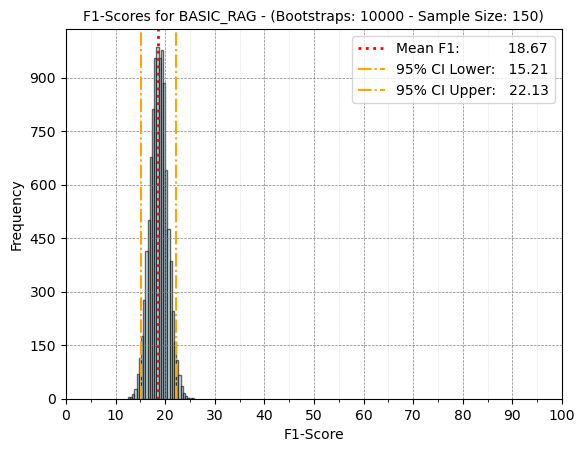

NameError: name 'end' is not defined

In [50]:
conduct_experiment(ldict_qas_for_boostrapping_sample, "BASIC_RAG", 1, context_needed=True)

##### Calculate results for BASIC_RAG_DONT_LIE

============= Creating results folder for BASIC_RAG_DONT_LIE =============
============= Calculating scores for BASIC_RAG_DONT_LIE =============
SAMPLE_SIZE: 500
current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 12

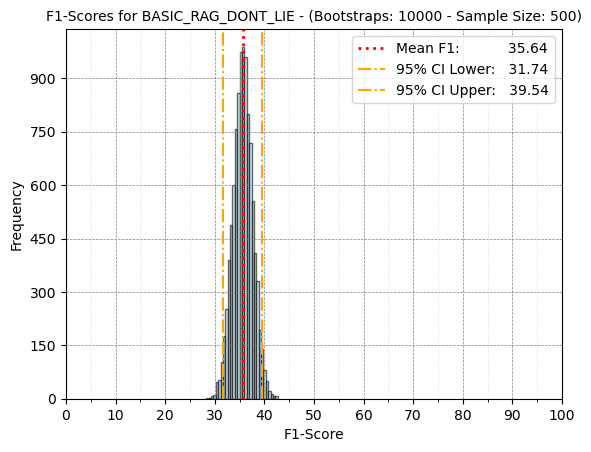

In [34]:
conduct_experiment(ldict_qas_for_boostrapping_sample, "BASIC_RAG_DONT_LIE", 2, context_needed=True)

##### Caclulation for BASIC_RAG_SUPPRESS_ANSWSERS

In [36]:
#conduct_experiment(ldict_qas_for_boostrapping, "BASIC_RAG_SUPPRESS_ANSWERS", 2, context_needed=True, suppress_answers=True)

##### Calculation for BASIC_RAG_HYDE_ANSWERS

============= Creating results folder for BASIC_RAG_HYDE =============
============= Calculating scores for BASIC_RAG_HYDE =============
SAMPLE_SIZE: 500
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Please only use the following pieces of retrieved context to answer the question.
    Use ten words maximum and keep the answer concise.

    Question: {question}
    Context: {context}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing question 130...
Processing question 140...
Processing question 150...
Processing question 160...
Processing question 170...
Processing question 180...
Processing question 190...
Processing question 200...
Pr

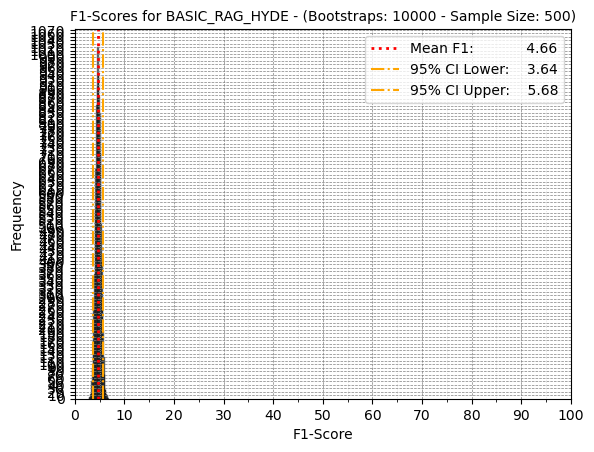

In [37]:
conduct_experiment(ldict_qas_for_boostrapping_sample, "BASIC_RAG_HYDE", 1, context_needed=True, suppress_answers=False    )

============= Creating results folder for FULL_RAG =============
============= Calculating scores for FULL_RAG =============
SAMPLE_SIZE: 150
current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing ques

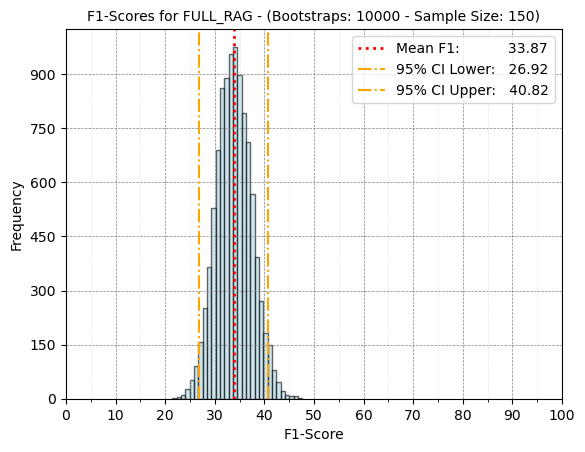

In [ ]:
conduct_experiment(ldict_qas_for_hyde_bootstrapping_sample, "FULL_RAG", 2, context_needed=True, suppress_answers=False)

In [47]:
for k,v in execution_times.items():
    print(f"Execution times (in seconds): \n")
    print(f"{k}: {v:.2f}")  

Execution times (in seconds): 

FULL_RAG: 87.87
